In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('iter.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,CACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCG...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGT...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 89429.45it/s]


[200, 486, 678, 765, 807, 855, 869, 931, 950, 958, 983, 1045, 1056, 1081, 1109, 1149, 1169, 1211, 1227, 1276, 1303, 1310, 1369, 1359, 1393, 1447, 1466, 1500, 1507, 1552, 1562, 1625, 1632, 1667, 1675, 1741, 1791, 1818, 1848, 1882, 1922, 1901, 1918, 1946, 2018, 2087, 2077, 2128, 2099, 2095, 2203, 2214, 2193, 2244, 2264, 2283, 2309, 2320, 2357, 2422, 2440, 2467, 2465, 2486, 2549, 2546, 2558, 2622, 2648, 2693, 2732, 2728, 2726, 2775, 2834, 2815, 2846, 2889, 2886, 2956, 2956, 3020, 2982, 3033, 3056, 3114, 3097, 3142, 3164, 3198, 3183, 3184, 3300, 3358, 3345, 3386, 3395, 3403, 3516, 3458, 3476, 3500, 3662, 3634, 3614, 3631, 3661, 3706, 3720, 4856]


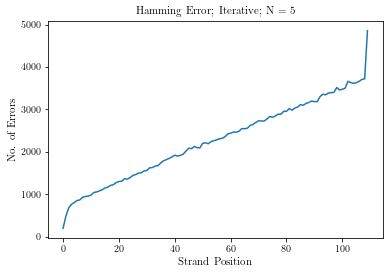

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; Iterative; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-iter-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:05<00:00, 1726.45it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


C -> AG 7
C -> AT 7
T -> CG 9
C -> GT 12
G -> A 13
G -> C 28
T ->  34
C ->  37
G -> T 40
A -> C 48
A -> T 48
A -> G 51
C -> A 54
C -> G 55
C -> T 66
T -> A 73
T -> G 79
T -> C 92
A ->  179
G ->  203
 -> T 1360
 -> A 1509
 -> C 1668
 -> G 1760


 -> G @ 104 6
 -> A @ 32 6
 -> A @ 81 6
 -> C @ 41 6
 -> A @ 71 6
 -> G @ 29 6
 -> A @ 72 6
 -> T @ 90 6
 -> G @ 56 6
 -> A @ 79 6
 -> A @ 25 6
 -> A @ 78 6
 -> C @ 38 6
 -> A @ 77 6
 -> C @ 108 6
 -> T @ 88 6
 -> A @ 75 6
 -> A @ 68 6
 -> T @ 65 6
 -> G @ 96 6
 -> C @ 10 6
 -> C @ 83 6
 -> C @ 61 6
 -> A @ 89 6
 -> A @ 48 6
 -> A @ 47 6
 -> T @ 41 6
 -> A @ 50 6
 -> A @ 54 6
 -> T @ 54 6
 -> A @ 64 6
 -> A @ 58 6
 -> C @ 52 6
 -> A @ 65 6
 -> T @ 62 6
 -> C @ 68 6
 -> C @ 103 6
 -> A @ 98 6
 -> C @ 13 7
 -> T @ 100 7
 -> C @ 15 7
T ->  @ 110 7
C -> AT @ 110 7
 -> T @ 91 7
 -> T @ 63 7
 -> T @ 35 7
 -> T @ 38 7
 -> T @ 40 7
 -> T @ 53 7
 -> G @ 59 7
 -> A @ 102 7
 -> A @ 96 7
 -> G @ 61 7
 -> T @ 77 7
 -> A @ 95 7
 -> C @ 102 7
C -> AG @ 110 7
 -> A @ 11 7
 -> T @ 14 7
 -> A @ 69 7
 -> C @ 90 7
 -> C @ 43 7
 -> C @ 9 7
 -> A @ 28 7
 -> A @ 45 7
 -> C @ 99 7
 -> C @ 82 7
 -> C @ 92 7
 -> A @ 23 7
 -> C @ 8 7
 -> G @ 27 7
 -> A @ 21 7
 -> A @ 15 7
 -> A @ 82 7
 -> A @ 67 7
 -> A @ 87 7
 

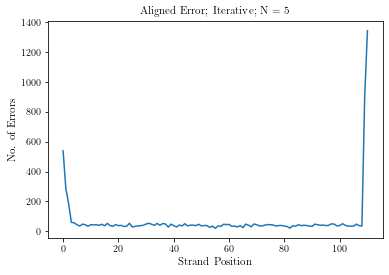

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; Iterative; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-iter-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[173, 66, 60, 12, 15, 15, 10, 12, 16, 8, 15, 13, 9, 9, 11, 8, 14, 11, 5, 11, 12, 10, 10, 3, 14, 4, 9, 7, 8, 6, 13, 11, 16, 12, 16, 16, 12, 17, 5, 14, 12, 8, 10, 14, 15, 9, 11, 10, 4, 12, 9, 5, 15, 9, 9, 3, 6, 10, 18, 7, 16, 7, 10, 8, 9, 2, 8, 12, 9, 11, 8, 10, 9, 15, 13, 12, 8, 12, 14, 9, 5, 9, 3, 9, 8, 10, 9, 10, 8, 8, 8, 11, 16, 5, 14, 9, 6, 10, 14, 9, 8, 19, 16, 9, 6, 9, 12, 9, 9, 268, 108]
[162, 93, 64, 17, 14, 7, 18, 14, 7, 7, 6, 9, 10, 7, 15, 7, 17, 8, 14, 10, 8, 9, 10, 19, 12, 9, 9, 12, 10, 10, 10, 11, 15, 8, 17, 13, 12, 8, 6, 11, 9, 6, 15, 7, 13, 9, 11, 11, 14, 8, 9, 12, 6, 2, 10, 4, 13, 8, 10, 13, 9, 6, 11, 8, 8, 7, 16, 10, 6, 18, 11, 10, 11, 10, 12, 10, 11, 7, 10, 11, 8, 10, 7, 6, 11, 8, 10, 14, 13, 16, 7, 16, 7, 13, 10, 9, 11, 20, 16, 7, 12, 10, 7, 6, 10, 10, 12, 5, 6, 195, 59]
[172, 105, 40, 16, 16, 9, 2, 8, 9, 4, 9, 7, 14, 9, 12, 7, 8, 7, 5, 10, 9, 7, 9, 7, 11, 6, 9, 8, 7, 12, 11, 9, 6, 9, 8, 4, 10, 12, 10, 11, 8, 9, 8, 5, 9, 7, 10, 6, 6, 12, 6, 8, 3, 7, 6, 2, 7, 9, 6, 15,

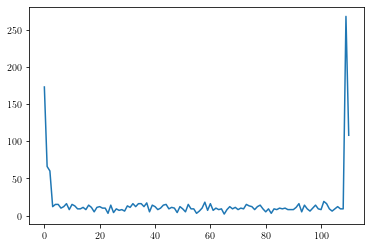

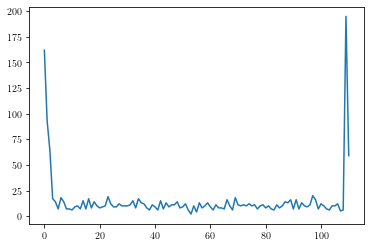

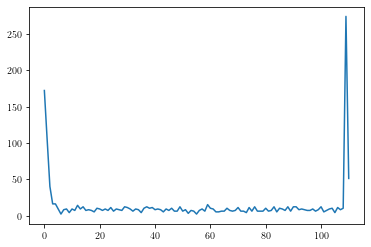

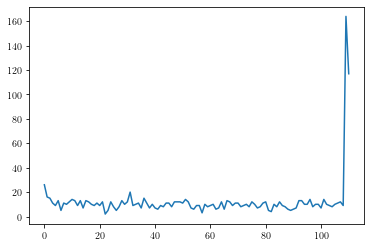

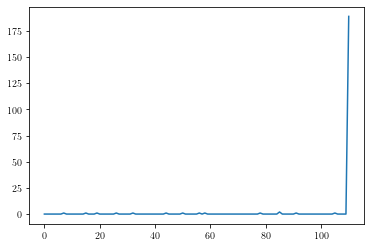

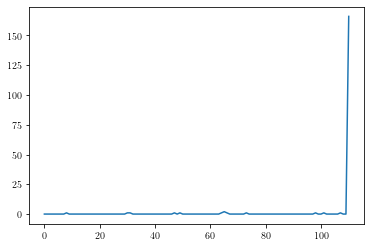

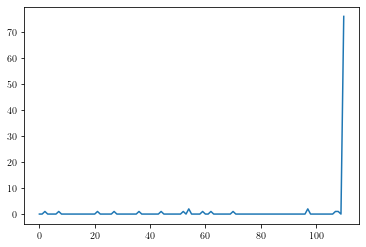

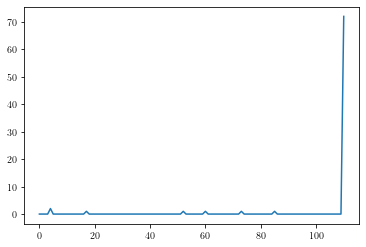

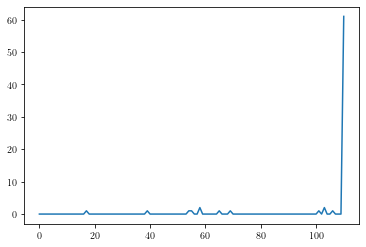

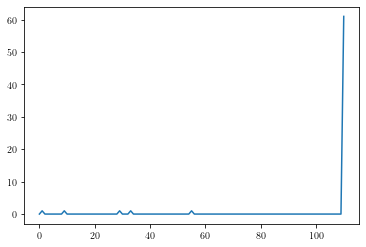

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)